In [1]:
import pandas as pd
import configparser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
inifile = configparser.ConfigParser()
inifile.read('../config.ini')
df_wine = pd.read_csv(
    inifile.get('url', 'wine'), header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
np.set_printoptions(precision=4)

In [3]:
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n'  %(label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [4]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

In [5]:
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [6]:
print('Class label distribution: %s' %(np.bincount(y_train)[1:]))

Class label distribution: [40 49 35]


In [7]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

In [8]:
print('Scaled within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [9]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [10]:
print('Between-class scatter matrix: %sx%s' %(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [11]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [12]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [13]:
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [14]:
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
3.92652341788e-14
3.92652341788e-14
3.44088355643e-14
3.44088355643e-14
3.19031533803e-14
2.84217094304e-14
2.6288885217e-14
1.71108212593e-14
7.06799262223e-15
1.58220170494e-15
1.44691688122e-15


In [15]:
tot = sum(eigen_vals.real)

In [16]:
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

In [17]:
cum_discr = np.cumsum(discr)

In [18]:
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')

<Container object of 13 artists>

In [19]:
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')

In [20]:
plt.ylabel('"discriminability" ratio')

Text(0,0.5,'"discriminability" ratio')

In [21]:
plt.xlabel('Linear Discriminants')

Text(0.5,0,'Linear Discriminants')

In [22]:
plt.ylim([-0.1, 1.1])

(-0.1, 1.1)

In [23]:
plt.legend(loc='best')

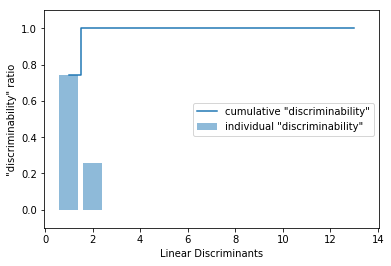

In [24]:
plt.show()

In [25]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

In [26]:
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


In [27]:
X_train_lda = X_train_std.dot(w)

In [28]:
colors = ['r', 'b', 'g']

In [29]:
markers = ['s', 'x', 'o']

In [30]:
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0] * (-1), X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)

In [31]:
plt.xlabel('LD 1')

Text(0.5,0,'LD 1')

In [32]:
plt.ylabel('LD 2')

Text(0,0.5,'LD 2')

In [33]:
plt.legend(loc='lower right')

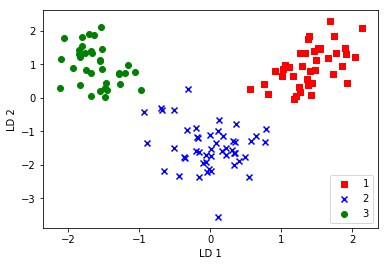

In [34]:
plt.show()